#BY SRINATH SAI TRIPURANENI - A20338902.

In [1]:
!pip install pyspark # installing pyspark 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from pyspark import SparkContext
sc= SparkContext("local", "Assignment-3, BDA 2022") #initializing spark context.

In [3]:
import math
import numpy as np  #importing necessary packages.
import matplotlib.pyplot as plt


In [4]:
textdata=sc.textFile('/content/data.txt') #reading the data.

In [5]:
main=textdata.map(lambda x: x.split()) #getting every line as list of by spliting based on space and use map function. 

In [6]:
textdata.unpersist() #unpersisting textdata which is not useful after this.
#main.take(1)

/content/data.txt MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0

In [7]:
def make_float(x): #a function constructed to make very point as float.
  return float(x)
  


In [8]:
main=main.map(lambda x :[make_float(i) for i in x]) #here lambda takes every line in form of list and for loop is used to take every value of line in text form to float .

In [9]:
#main.take(1)

In [10]:
main=main.zipWithIndex() # indexing every line because here every line is a datapoint and we need a certain number which will be index here, 
#to get cluster numbers or group them to certain clusters here it is also used for centeroids initialization.
main=main.map(lambda x:(x[1],x[0])) ##reversing index number to key and list of values to values for easy computations.

In [11]:
no_of_clusters=10   #initializing parameters.
no_of_iterations=20

#Initialization of one random centeroid.

In [12]:
centroids=sc.parallelize(main.takeSample(False,1)) # based on the research done in kmeans directly taking takesample of one cluster.

In [13]:
#centroids.take(1)

#Iterating untill we get 10 clusters

In [14]:
centroids1=sc.broadcast(centroids.collect()) #broadcasting one centroid initially.

In [15]:
#Main logic of below function is every point is passed here and we will have centroids updated and broadcasted for every iteration.
# Now for each centroid in broadcasted value we will calculate euclidean distance with the point passed and store all distances in list.
#As largest distance can be next centroid , we will take max of list square that and pass as one argument. And another arguement is point index for taking as next centroid.
def computation_longest_distance(x):
  distances=[] # list for determining max distance.
  for i in centroids1.value: #iterating in centroid broadcasted list.
    dist=0
    for j in range(0,58): #as our points are 58 dimensions.
      dist+=np.square(x[1][j]-i[1][j])
    distances.append(math.sqrt(dist)) #logic of euclidean distance computation.
  longest_distance=max(distances) # getting maxdistance from the list fro next centroid.
  return (x[0],np.square(longest_distance)) #returning 2 parameters which are mentioned above.

Experimenting idea of making next centroid before for loop 

In [16]:
centroids1_indexes=sc.broadcast(centroids.keys().collect()) # taking keys for making next centroids.

In [17]:
"""for i in centroids1_indexes.value:
  print(i) """

'for i in centroids1_indexes.value:\n  print(i) '

In [18]:
 """centroids_filtered1=main.filter(lambda x : x[0] not in centroids1_indexes.value)
 longest_distances_values_rdd1=centroids_filtered1.map(lambda x: computation_longest_distance(x))"""


'centroids_filtered1=main.filter(lambda x : x[0] not in centroids1_indexes.value)\nlongest_distances_values_rdd1=centroids_filtered1.map(lambda x: computation_longest_distance(x))'

In [19]:
"""longest_distance_values1=longest_distances_values_rdd1.values()"""

'longest_distance_values1=longest_distances_values_rdd1.values()'

In [20]:
"""x=longest_distance_values1.sum()
print(x)"""

'x=longest_distance_values1.sum()\nprint(x)'

In [21]:
#max_dist=max_dist.map(lambda x:(x[0],x[1]/x))

#Now iteratively making centroids

In [22]:
from array import * #importing array module for random choice (will be  clearer in next loop.)

In [23]:
for count in range(0,9):
  centroids_filtered=main.filter(lambda x : x[0] not in centroids1_indexes.value) 
  # first we filter the points that are not centroids . This is because our aim is telling next centroid frompresent centroids for that we need to filter centroids for getting next perfect
  #centroid.
  longest_distances_rdd=centroids_filtered.map(lambda x:computation_longest_distance(x))
  #from filtered rdd we calculate longest distance to centroids and will be getting  square of longest distance as value and point index as keys.
  longest_distances_values=longest_distances_rdd.values()
  #taking longest distances of each point in seperate value.
  total_distance=longest_distances_values.sum()
  #getting sum of all longest distances of each point with centroids , this is because we take probability of next point as centroid which is proportional to distance with centroids.
  #that means larger the distance to centroid ,larger is the probabilty of next centroid it can be.
  longest_distances_rdd=longest_distances_rdd.map(lambda x:(x[0],x[1]/total_distance))
  #As probability means favourable outcomes/total outcomes, here total is total distance which is sum of all values and favourable outcome is longest distance of each point.
  #Therefore dividing by total to convert into probabilities.
  longest_distances_indices=[] #list to have indexes of each point that is in longest distance rdd.
  longest_distances_values_original=[] #list to have probabilities of farness that is longest value of each point/total 
  for i in longest_distances_rdd.keys().collect():
    longest_distances_indices.append(i)   #Logic to add all indexes 
  for i in longest_distances_rdd.values().collect():
    longest_distances_values_original.append(i) #logic to add all probabilities of farness.
  longest_distances_indices=array('i',longest_distances_indices) # converting the longest_distances_indices to array from list.
  longest_distances_values_original=array('f',longest_distances_values_original) #converting the longest_distances_values_original to array from list.
  #link referred for array declaration:- links referred:- https://www.studytonight.com/python-howtos/how-to-declare-an-array-in-python
  random_centroid=np.random.choice(longest_distances_indices,1,p=longest_distances_values_original)
  # we can get multiple points which can have almost same probability of farness but we need a point from all those which can be next centroid so taking random choice which takes 
  # one value and this is our next centroid.
  # link reffered for logic of random choice is :- https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
  next_centroid=main.filter(lambda x: x[0]==random_centroid)
  #the next centroid will be filtered from main to add into intial one centroid rdd iteratively.
  centroids=centroids+next_centroid # making union of next centroid to current centroids.
  centroids1=sc.broadcast(centroids.collect()) # broadcasting after adding new centroids for next centroid determination process from the function computation_largest_distance.
  centroids1_indexes=sc.broadcast(centroids.keys().collect()) # broadcasting new centroids rdd keys which will be useful in line one of this for loop.

  #Link reffered for the Logic of kmeans++ centroids initiallization is:- https://www.geeksforgeeks.org/ml-k-means-algorithm/


now centroids is RDD in which there are 10 centroids that are obtained iteratively and this is the only difference between kmeans++ and kmeans.

#As we got centroids after iteration now we have centroids, and clustering is as same as kmeans therefore copying my own code of kmeans.

#Euclidian distance calculation

In [24]:
def get_min_dist(distances):
  return min(distances)    #A function constructed to return minimum distance from list of distances.

In [25]:
#The main logic of below function is every point is passed to this function. and we will be having 10 centroids with indices and 58 dimensions information as broadcasted variable.
#Now for every centroid we will calculate euclidian distance to the one point and stored in list. At the same time we will be maintaining a hashmap in which distance is key and respective 
#centroid index as value. After iterating each centroid broadcasted we will be having hashmap of distance between one point to one centroid as key and respective centeroid index as value.
#when we get min distance form that hashmap respective value which is centeroid index is returned.

def calculate_euclidian_distance(x): # A function constructed to get which cluster index is minimum distant to evry single point.
  cache={}#initializing hashmap of distances as key and centroid indices as valus.
  distances=[] #initializing list of distances for determining minimum distance to get grouped with that respective centeroid.
  for j in centroids.value: #Here centroids rdd is broadcasted and respectively looped .
    dist=0
    for i in range(0,58):  # as our points have 58 dimensions iterating for calculating euclidian distance.
      dist+=(np.square(j[1][i]-x[1][i])) 
    euclidian_distance=math.sqrt(dist)
    distances.append(euclidian_distance)   #Logic of euclidian distance.
    cache[euclidian_distance]=j[0] #adding to hashmaps with each distance as key and respective centeroid index as value.
  y=get_min_dist(distances)   #minimum distance is retrieved from the list from above function.
  return (cache[y],np.square(y),x[1]) # the point which is nearest to a centroid that index is returned from hashmap, another parameter is cost function and another
  #parameter is point values.

In [26]:
def make_list(x):
  return list(x) # A Function constructed to make list of every item.

In [27]:
cost_function_per_iteration=[] # a list of cost function per iteration is initialized which will be appended in iteration loop.

In [28]:
def makesum(x):
  return np.sum(x[1]) #by using np module we sum list of elements.

#Logic of combining point to nearest cluster, taking new centeroid by averaging and repeating from step-2 for 20 iterations.

In [29]:
centroids=sc.broadcast(centroids.collect())
for i in range(no_of_iterations+1):
  clustersRDD=main.map(lambda x : calculate_euclidian_distance(x))
  """clustersRDD=clustersRDD.map(lambda x: (x[0],x[2]))  #after calculating euclidian distance taking centroid index and point information as map.
  clustersRDD=clustersRDD.reduceByKey(lambda x :make_list(x)) #experimented by reducebykey but as mapside transformations are not neccesary for this operation, just taking group bykey. 
  #Main idea is grouping centeroids indices that have same key after eculidian distance.
  #clustersRDD=clustersRDD.mapValues() # collecting all the values that are centeroids with same key grouped values.
  #clustersRDD=clustersRDD.map(lambda x:(x[0],np.average(x[1],axis =0)))""" # we need to make average along axis=0 for getting new centeroid after combining nearet point to that cluster.
  centroids=sc.broadcast(clustersRDD.map(lambda x: (x[0],x[2])).groupByKey().mapValues(make_list).map(lambda x:(x[0],np.average(x[1],axis=0))).collect())
 # Combining above logic in a line for reducing complexity of lines of code.
 #After passing every line to calculate_euclidian_distance we get nearest centeroid index and that point, so groupbykey is useful to group values for same key.
 #After grouping now we need to make average of new point and centroid for new centroid and this is done by doing np.average(x[1],axis=0) and this will be added to centroids broadcast.
 #Link referred for the reason of using groupby :-  https://www.hadoopinrealworld.com/what-is-the-difference-between-groupbykey-and-reducebykey-in-spark/#:~:text=Both%20reduceByKey%20and%20groupByKey%20result,do%20a%20map%20side%20combine.
  cost_function_per_iteration.append(clustersRDD.map(lambda x : x[1]).sum())
  # as cost function also returned in the function of calculation of euclidian distance it will be appended to list.



#printing cost function for each iteration.

In [30]:
for i in range(1,len(cost_function_per_iteration)):
  print('For Iteration -' + str(i) + ' , ' ' the cost_function is :' + str(cost_function_per_iteration[i-1])) # printing for each iteration.

For Iteration -1 ,  the cost_function is :353321151.45895207
For Iteration -2 ,  the cost_function is :299376206.8942056
For Iteration -3 ,  the cost_function is :243253871.8586065
For Iteration -4 ,  the cost_function is :228424865.87237266
For Iteration -5 ,  the cost_function is :224299446.7104634
For Iteration -6 ,  the cost_function is :221001787.07807767
For Iteration -7 ,  the cost_function is :218027330.7842424
For Iteration -8 ,  the cost_function is :215075820.94001105
For Iteration -9 ,  the cost_function is :211988234.0318865
For Iteration -10 ,  the cost_function is :209273968.74396503
For Iteration -11 ,  the cost_function is :207803601.49845865
For Iteration -12 ,  the cost_function is :206436827.486607
For Iteration -13 ,  the cost_function is :204324739.78428644
For Iteration -14 ,  the cost_function is :202700971.8847076
For Iteration -15 ,  the cost_function is :202052314.4468814
For Iteration -16 ,  the cost_function is :201614688.7530253
For Iteration -17 ,  the co

#Plotting a graph

In [31]:
x=np.arange(1,22,1)
#taking x-axis values.

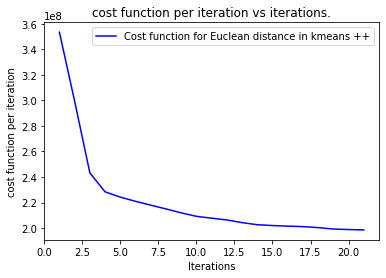

In [32]:
fig, ax = plt.subplots() 
ax.plot(x, cost_function_per_iteration, color='blue',label="Cost function for Euclean distance in kmeans ++")
ax.legend(loc=0)
plt.xlabel('Iterations')       #plotting k-means++ graph.
plt.ylabel('cost function per iteration')
plt.title('cost function per iteration vs iterations.')
plt.show()

#Calculation of percentage change

In [33]:
#here as cost_function_per_iteration is stored in list first iteration would be that list[0] th element and 10th iterated value will be that list[9]th value.
percetange_change=((cost_function_per_iteration[0]-cost_function_per_iteration[9])/(cost_function_per_iteration[0]))*100
print(" The percentage change in cost function from 1st iteration to 10th iteration using Euclidiean distance in kmeans ++ is :" + str(percetange_change) + ' % ')
#calculating percentage change from the list created as first element of list will be first iterated cost function. and last element will be last iterated cost function value.

 The percentage change in cost function from 1st iteration to 10th iteration using Euclidiean distance in kmeans ++ is :40.769476189064804 % 


#Writing centroids to file.

In [34]:
output_cache=[]
m=1
for i in centroids.value:                                         #appending centroids points in list.
  output_cache.append('Centroid ' + str(m) + ':-' + str(i[1]))
  m+=1

In [35]:
rdd=sc.parallelize(output_cache) #converting list to rdd
rdd.coalesce(1).saveAsTextFile("centroids of kmeans++(2).txt") # saving to file from rdd.

#DELETING ALL RDDS FROM MEMORY FOR MEMORY EFFICIENCY.

In [36]:
rdd.unpersist()
clustersRDD.unpersist()
main.unpersist()
centroids.unpersist()     #unpersisting as there willbe no uses after centroids file.
longest_distances_rdd.unpersist()

PythonRDD[194] at RDD at PythonRDD.scala:53

#Comparision of performances of kmeans++ vs kmeans




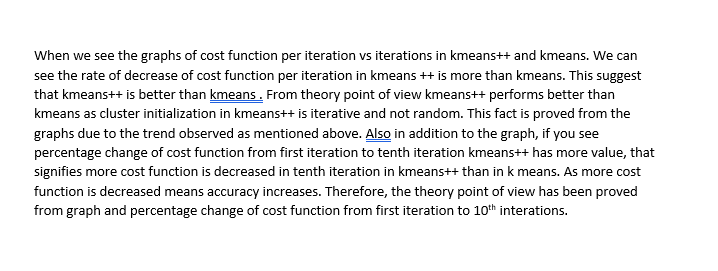

# everything is done by me individually.